# Jores et al 2021 Intepretation
**Authorship:**
Adam Klie (last updated: *06/08/2023*)
***
**Description:**
Notebook to interpret the best trained models on the Jores et al (2021) dataset.
***

In [6]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [4]:
# General imports
import os
import sys
import glob
import torch
import numpy as np

# EUGENe imports and settings
import eugene as eu
from eugene import preprocess as pp
from eugene import models
from eugene import interpret
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/jores21"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/jores21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/jores21/"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/jores21"

# EUGENe packages
import seqdata as sd
import motifdata as md
import seqpro as sp

# For illustrator editing
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqData version: {sd.__version__}")
print(f"PyTorch version: {torch.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Eugene version: 0.0.8
SeqData version: 0.0.1
PyTorch version: 2.0.0


# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [5]:
# Load in the preprcoessed test data with predictions
sdata_leaf = sd.open_zarr(os.path.join(settings.output_dir, "leaf", "jores21_leaf_test_predictions.zarr"))
sdata_proto = sd.open_zarr(os.path.join(settings.output_dir, "proto", "jores21_proto_test_predictions.zarr"))
sdata_combined = sd.open_zarr(os.path.join(settings.output_dir, "combined", "jores21_combined_test_predictions.zarr"))

# Load the best model

In [25]:
# Load them all but will choose one
leaf_model_file = glob.glob(os.path.join(settings.logging_dir, "hybrid", "leaf_trial_3", "checkpoints", "*"))[0]
leaf_model_arch = models.load_config(config_path="hybrid.yaml")
leaf_model = models.SequenceModule.load_from_checkpoint(leaf_model_file, arch=leaf_model_arch.arch)
proto_model_file = glob.glob(os.path.join(settings.logging_dir, "jores21_cnn", "proto_trial_3", "checkpoints", "*"))[0]
proto_model_arch = models.load_config(config_path="jores21_cnn.yaml")
proto_model = models.SequenceModule.load_from_checkpoint(proto_model_file, arch=proto_model_arch.arch)
combined_model_file = glob.glob(os.path.join(settings.logging_dir, "deepstarr", "combined_trial_5", "checkpoints", "*"))[0]
combined_model_arch = models.load_config(config_path="deepstarr.yaml")
combined_model = models.SequenceModule.load_from_checkpoint(combined_model_file, arch=combined_model_arch.arch)

[rank: 0] Global seed set to 3
[rank: 0] Global seed set to 3
[rank: 0] Global seed set to 5


In [7]:
# Choose which model you want to intepret
name = "proto"
model = leaf_model
sdata = sdata_leaf

# Feature attribution

In [8]:
# Run DeepLift with a simple all 0s reference
method = "DeepLift"
interpret.attribute_sdata(
    model,
    sdata,
    method=method,
    batch_size=128,
    reference_type="zero",
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}
)

Computing saliency on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

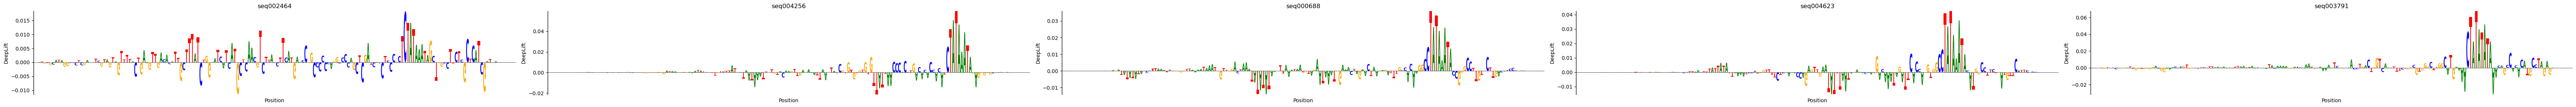

In [9]:
# Grab the top 5 in terms of predictions to plot tracks for
top5_inds = sdata["hybrid_trial_3_enrichment_predictions"].to_series().sort_values(ascending=False).iloc[:5].index
top5_ids = sdata["id"][top5_inds].values
top5_vals = sdata["hybrid_trial_3_enrichment_predictions"][top5_inds].values

pl.multiseq_track(
    sdata,
    seq_ids=top5_ids,
    attrs_keys = f"{method}_attrs",
    ylabs=method,
    height=3,
    width=70,
    save=os.path.join(settings.figure_dir, name, f"{name}_best_model_feature_attr.pdf")
)

# Filter viz

In [10]:
# Select the layer you want to interpret
layer_name = "arch.conv1d_tower.layers.1"

In [11]:
# Generate pfms from filters
interpret.generate_pfms_sdata(
    model,
    sdata,
    seq_key="ohe_seq",
    layer_name=layer_name,
    kernel_size=13,
    num_seqlets=100,
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)},
)

Getting activations on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

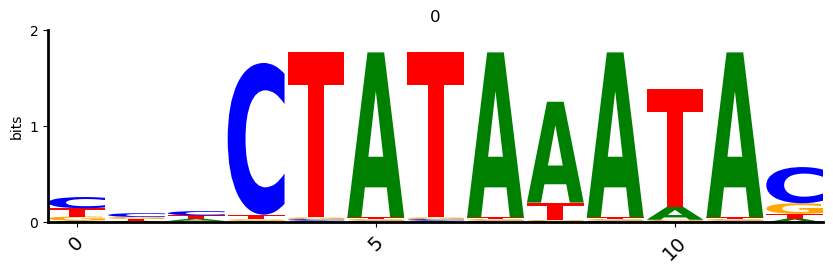

In [13]:
# Visualize a filter of choice
pl.filter_viz(
    sdata,
    filter_num=0,
    pfms_key=f"{layer_name}_pfms",
)

In [ ]:
# Visualize multiple filters at once and save
for i in range(8):
    start_filter = i*32
    end_filter = (i*32) + 32
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    pl.multifilter_viz(
        sdata,
        filter_nums=range(start_filter, end_filter),
        pfms_key=f"{layer_name}_pfms",
        num_rows=8,
        num_cols=4,
        titles=[f"filter {i}" for i in range(start_filter, end_filter)],
        save=os.path.join(settings.figure_dir, name, f"{name}_best_model_filters{start_filter+1}-{end_filter}_viz.pdf")
    )

In [15]:
# Save all the filter pfms from above as meme format for submission to TomTom
interpret.filters_to_meme_sdata(
    sdata,
    filters_key=f"{layer_name}_pfms",
    output_dir=os.path.join(settings.output_dir, name),
    filename=f"{name}_best_model_filters.meme"
)

Output directory already exists: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/jores21/leaf
Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/jores21/leaf/leaf_best_model_filters.meme


In [16]:
# Save the predictions and interpretations to zarr
sd.to_zarr(sdata, os.path.join(settings.output_dir, name, f"jores21_{name}_test_predictions_and_interpretations.zarr"), load_first=True, mode="w")

# *in silico* evolution 

In [18]:
# Load in sequences that were evolved in the published paper
sdata_evolve = sd.read_table(
    name="seq",
    tables=os.path.join(settings.dataset_dir, "promoters_for_evolution.tsv"),
    out=os.path.join(settings.dataset_dir, "promoters_for_evolution.zarr"),
    seq_col="sequence",
    fixed_length=False,
    batch_size=310,
    overwrite=True
)
pp.ohe_seqs_sdata(sdata_evolve)

310it [00:00, 2914.65it/s]


In [21]:
# Evolve them using the best model across 10 rounds
interpret.evolve_seqs_sdata(
    model,
    sdata_evolve,
    rounds=10
)

Evolving seqs:   0%|          | 0/310 [00:00<?, ?it/s]

here


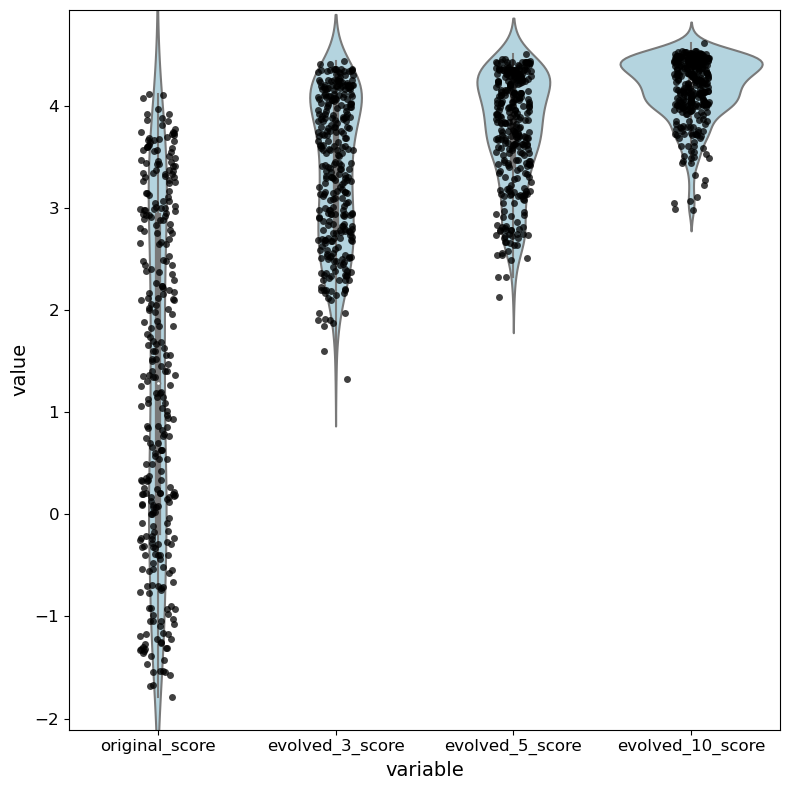

In [24]:
# Plot the distribution of scores at different rounds of evolution
pl.violinplot(
    sdata_evolve,
    groupby=["original_score", "evolved_3_score", "evolved_5_score", "evolved_10_score"],
    xlabel="Evolution Round",
    ylabel="Score",
    color = "lightblue",
    save=os.path.join(settings.figure_dir, name, f"{name}_best_model_evolution_summary.pdf")
)

In [25]:
# Write out the evolved sequences and their scores (along with the original sequences)
sd.to_zarr(sdata_evolve, os.path.join(settings.output_dir, name, f"jores21_{name}_evolved_sequences.zarr"), load_first=True, mode="w")

# Positional GIA

In [20]:
# Reread in the evolved sequences and their scores
sdata_evolve = sd.open_zarr(os.path.join(settings.output_dir, name, f"jores21_{name}_evolved_sequences.zarr"))

In [21]:
# Read in the motif
motif_set = md.read_meme(os.path.join(settings.dataset_dir, "CPEs.meme"))
motif = motif_set["TATA"]
feat_name = motif.name
pfm = motif.pfm
consensus = motif.consensus

# Generate some baseline sequences
zero_pfm = np.zeros(pfm.shape)
rand_pfm = sp.ohe(sp.random_seq(pfm.shape[0]), alphabet=sp.ALPHABETS["DNA"])
shuffled_pfm = sp.ohe(sp.k_shuffle(consensus, k=1).tobytes().decode(), alphabet=sp.ALPHABETS["DNA"])
zero_pfm.shape, rand_pfm.shape, shuffled_pfm.shape

((16, 4), (16, 4), (16, 4))

In [22]:
# Slide the TATA motif across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_evolve,
    seq_key="ohe_seq",
    id_key="name",
    feature=pfm,
    feature_name=feat_name,
    encoding="onehot",
    store_key=f"slide_{feat_name}",
)

# Slide a random seq across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_evolve,
    seq_key="ohe_seq",
    id_key="name",
    feature=rand_pfm,
    feature_name="random",
    encoding="onehot",
    store_key=f"slide_random",
)

# Slide a zero ohe seq across the sequences 
interpret.positional_gia_sdata(
    model,
    sdata_evolve,
    seq_key="ohe_seq",
    id_key="name",
    feature=zero_pfm,
    feature_name="zero",
    encoding="onehot",
    store_key=f"slide_zero",
)

# Slide a TATA shuffled ohe seq across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_evolve,
    seq_key="ohe_seq",
    id_key="name",
    feature=shuffled_pfm,
    feature_name="shuffled",
    encoding="onehot",
    store_key=f"slide_shuffled",
)   

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

In [24]:
# Check the average percentage increase across the sequences and positions
mean_original = sdata_evolve["original_score"].values.mean()
avg_increase = np.mean(np.subtract(sdata_evolve["slide_TATA"].values, np.expand_dims(sdata_evolve["original_score"].values, axis=1)), axis=1)
(avg_increase.mean()/mean_original).mean()*100

93.40898394584656

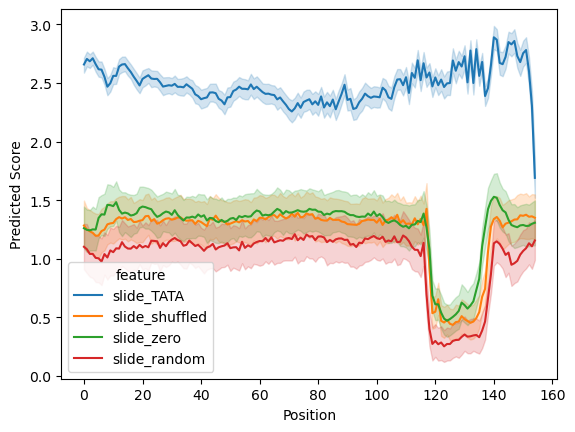

In [35]:
# Generate a line plot
pl.positional_gia_plot(
    sdata_evolve,
    keys=[f"slide_{feat_name}", "slide_shuffled", "slide_zero", "slide_random"],
    id_key="name",
    save=os.path.join(settings.figure_dir, name, f"{name}_best_model_feature_implant_TATA.pdf")
)

In [36]:
# Save the evolved sequences  with the TATA implanted scores as well
sd.to_zarr(sdata_evolve, os.path.join(settings.output_dir, name, f"jores21_{name}_evolved_sequences_with_TATA_implant.zarr"), load_first=True, mode="w")

# DONE!

---

# Scratch

In [17]:
sd.open_zarr(os.path.join(settings.output_dir, name, f"jores21_{name}_test_predictions_and_interpretations.zarr"))

<xarray.Dataset>
Dimensions:                                     (_sequence: 7154, _ohe: 4,
                                                 length: 170,
                                                 _num_kernels: 256,
                                                 _kernel_size: 13)
Dimensions without coordinates: _sequence, _ohe, length, _num_kernels,
                                _kernel_size
Data variables: (12/41)
    DeepLift_attrs                              (_sequence, _ohe, length) float32 dask.array<chunksize=(1789, 1, 85), meta=np.ndarray>
    GC                                          (_sequence) float64 dask.array<chunksize=(7154,), meta=np.ndarray>
    UTR                                         (_sequence) float64 dask.array<chunksize=(7154,), meta=np.ndarray>
    arch.conv1d_tower.layers.1_pfms             (_num_kernels, _kernel_size, _ohe) float32 dask.array<chunksize=(256, 13, 4), meta=np.ndarray>
    barcodes                                    (_sequence) float64 dask.array<chunksize=(7154,), meta=np.ndarray>
    batch                                       <U4 ...
    ...                                          ...
    set                                         (_sequence) object dask.array<chunksize=(7154,), meta=np.ndarray>
    sp                                          (_sequence) object dask.array<chunksize=(7154,), meta=np.ndarray>
    start                                       (_sequence) object dask.array<chunksize=(7154,), meta=np.ndarray>
    strand                                      (_sequence) object dask.array<chunksize=(7154,), meta=np.ndarray>
    target                                      (_sequence) float64 dask.array<chunksize=(7154,), meta=np.ndarray>
    type                                        (_sequence) object dask.array<chunksize=(7154,), meta=np.ndarray>
Attributes:
    max_jitter:  0

In [19]:
sd.open_zarr(os.path.join(settings.output_dir, name, f"jores21_{name}_evolved_sequences.zarr"))

<xarray.Dataset>
Dimensions:           (_sequence: 310, _ohe: 4, length: 170)
Dimensions without coordinates: _sequence, _ohe, length
Data variables: (12/15)
    evolved_10_score  (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_1_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_2_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_3_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_4_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_5_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    ...                ...
    evolved_9_score   (_sequence) float64 dask.array<chunksize=(310,), meta=np.ndarray>
    evolved_seqs      (_sequence, _ohe, length) float64 dask.array<chunksize=(155, 2, 170), meta=np.ndarray>
    name              (_sequence) object dask.array<chunksize=(310,), meta=np.ndarray>
    ohe_seq           (_sequence, length, _ohe) uint8 dask.array<chunksize=(310, 170, 4), meta=np.ndarray>
    original_score    (_sequence) float32 dask.array<chunksize=(310,), meta=np.ndarray>
    seq               (_sequence) |S170 dask.array<chunksize=(310,), meta=np.ndarray>

In [ ]:
pfm_dfs = pfms_to_df_dict(pfms)
ppms = pfms_to_ppms(pfms, pseudocount=1)
pwms = ppms_to_pwms(ppms)
infos = ppms_to_igms(ppms)
ppics = per_position_ic(ppms)
tot_ics = ppics.sum(axis=1)

In [ ]:
# Sort by total information content
sort_idx = np.argsort(tot_ics)[::-1]
sort_idx[:5]

In [ ]:
from tqdm.auto import tqdm
from seqexplainer import evolution
def evolve_seqs_sdata(
    model: torch.nn.Module, 
    sdata, 
    rounds: int, 
    seq_key: str = "ohe_seq",
    axis_order = ("_sequence", "_ohe", "length"),
    add_seqs=True,
    return_seqs: bool = False, 
    device: str = "cpu", 
    batch_size: int = 128,
    copy: bool = False, 
    **kwargs
):
    """
    In silico evolve a set of sequences that are stored in a SeqData object.

    Parameters
    ----------
    model: torch.nn.Module  
        The model to score the sequences with
    sdata: SeqData  
        The SeqData object containing the sequences to evolve
    rounds: int
        The number of rounds of evolution to perform
    return_seqs: bool, optional
        Whether to return the evolved sequences
    device: str, optional
        Whether to use a 'cpu' or 'cuda'.
    copy: bool, optional
        Whether to copy the SeqData object before mutating it
    kwargs: dict, optional
        Additional arguments to pass to the evolution function
    
    Returns
    -------
    sdata: SeqData
        The SeqData object containing the evolved sequences
    """

    sdata = sdata.copy() if copy else sdata

    # Set device
    device = "cuda" if settings.gpus > 0 else "cpu" if device is None else device

    # Grab seqs
    ohe_seqs = sdata[seq_key].transpose(*axis_order).to_numpy()
    evolved_seqs = np.zeros(ohe_seqs.shape)
    deltas = np.zeros((sdata_evolve.dims["_sequence"], rounds))
    
    # Evolve seqs
    for i, ohe_seq in tqdm(enumerate(ohe_seqs), total=len(ohe_seqs), desc="Evolving seqs"):
        evolved_seq, delta, _ = evolution(model, ohe_seq, rounds=rounds, device=device)
        evolved_seqs[i] = evolved_seq
        deltas[i, :] = deltas[i, :] + delta

    # Get original scores
    orig_seqs = torch.tensor(ohe_seqs, dtype=torch.float32).to(device)
    original_scores = model.predict(orig_seqs, batch_size=batch_size, verbose=False).detach().cpu().numpy().squeeze()

    # Put evolved scores into sdata
    sdata["original_score"] = xr.DataArray(original_scores, dims="_sequence")
    sdata["evolved_1_score"] = xr.DataArray(original_scores + deltas[:, 0], dims="_sequence")
    for i in range(2, rounds + 1):
        sdata[f"evolved_{i}_score"] = xr.DataArray(sdata[f"evolved_{i-1}_score"] + deltas[:, i - 1], dims="_sequence")
    if return_seqs:
        evolved_seqs = torch.tensor(evolved_seqs, dtype=torch.float32)
        return evolved_seqs
    if add_seqs:
        sdata["evolved_seqs"] = xr.DataArray(evolved_seqs, dims=("_sequence", "_ohe", "length"))
    return sdata if copy else None

In [ ]:
from seqexplainer.preprocess._preprocess import dinuc_shuffle_seq
consensus, dinuc_shuffle_seq(consensus), k_shuffle(consensus, k=2).tobytes().decode()

In [ ]:
# if using naiveISM
sdata["ohe_seq"] = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length")
X1 = sdata["ohe_seq"].values
X2 = (sdata[f"{method}_attrs"]*-1).sum(dim="_ohe").values
X1.shape, X2.shape
# Multiply the one-hot encoded sequence with the saliency scores. X1 has shape 128,4,170 and X2 has shape 128,170.
# We need to expand X2 to 128,4,170 to be able to multiply it with X1.
X2 = np.expand_dims(X2, axis=1)
X2 = np.repeat(X2, 4, axis=1)
X2.shape
X = X1 * X2
sdata[f"{method}_attrs_sum"] = xr.DataArray(X, dims=["_sequence", "_ohe", "length"], coords=sdata["ohe_seq"].coords)